## EV Manufacturer Suggested Retail Prices (by Models)

**Data Source: US Department of Energy - Office of Energy efficiency & Renewable Energy**

URL: https://www.fueleconomy.gov/feg/PowerSearch.do?action=PowerSearch&year1=2016&year2=2023&minmsrpsel=0&maxmsrpsel=0&city=0&highway=0&combined=0&cbvtelectric=Electric&YearSel=2016-2023&MakeSel=&MarClassSel=&FuelTypeSel=&VehTypeSel=Electric&TranySel=&DriveTypeSel=&CylindersSel=&MpgSel=000&sortBy=Comb&Units=&url=SearchServlet&opt=new&minmsrp=0&maxmsrp=0&minmpg=0&maxmpg=0&sCharge=&tCharge=&startstop=&cylDeact=&rowLimit=50

Data Description: 

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os

In [2]:
# List of URLs for multiple pages
urls = [
    'https://www.fueleconomy.gov/feg/PowerSearch.do?action=noform&year1=2016&year2=2023&minmsrpsel=0&maxmsrpsel=0&city=0&hwy=0&comb=0&cbvtelectric=Electric&YearSel=2016-2023&make=&mclass=&vfuel=&vtype=Electric&trany=&drive=&cyl=&MpgSel=000&sortBy=Comb&Units=&url=SearchServlet&opt=new&minmsrp=0&maxmsrp=0&minmpg=0&maxmpg=0&sCharge=&tCharge=&startstop=&cylDeact=&rowLimit=200&pageno=1&tabView=2',
    'https://www.fueleconomy.gov/feg/PowerSearch.do?action=noform&year1=2016&year2=2023&minmsrpsel=0&maxmsrpsel=0&city=0&hwy=0&comb=0&cbvtelectric=Electric&YearSel=2016-2023&make=&mclass=&vfuel=&vtype=Electric&trany=&drive=&cyl=&MpgSel=000&sortBy=Comb&Units=&url=SearchServlet&opt=new&minmsrp=0&maxmsrp=0&minmpg=0&maxmpg=0&sCharge=&tCharge=&startstop=&cylDeact=&rowLimit=200&pageno=2&tabView=2',
    'https://www.fueleconomy.gov/feg/PowerSearch.do?action=noform&year1=2016&year2=2023&minmsrpsel=0&maxmsrpsel=0&city=0&hwy=0&comb=0&cbvtelectric=Electric&YearSel=2016-2023&make=&mclass=&vfuel=&vtype=Electric&trany=&drive=&cyl=&MpgSel=000&sortBy=Comb&Units=&url=SearchServlet&opt=new&minmsrp=0&maxmsrp=0&minmpg=0&maxmpg=0&sCharge=&tCharge=&startstop=&cylDeact=&rowLimit=200&pageno=3&tabView=2'
]

# Initialize lists for data storage
years = []
models = []
annual_fuel_costs = []
msrp_prices = []

# Loop over each URL to fetch data from multiple pages
for url in urls:
    # Send request and parse HTML
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all 'tr' tags with the 'ymm-row' class
    vehicle_rows = soup.find_all('tr', class_='ymm-row')

    # Loop over each 'ymm-row' and find the next row for cost and msrp
    for vehicle_row in vehicle_rows:
        # Get vehicle details
        vehicle_tag = vehicle_row.find('a')
        if vehicle_tag:
            vehicle_text = vehicle_tag.get_text(strip=True)
            year, model = vehicle_text.split(' ', 1)  # Split on the first space to separate year and model
            years.append(year)
            models.append(model)
        else:
            years.append(np.nan)
            models.append(np.nan)

        # Find the next sibling row for cost and MSRP
        cost_row = vehicle_row.find_next_sibling('tr')
        if cost_row:
            fuel_cost_tag = cost_row.find('td', class_='ann-fuel-cost')
            msrp_tag = cost_row.find('td', class_='msrp')

            # Check if MSRP exists, else skip this entry
            if msrp_tag:
                # Process fuel cost
                if fuel_cost_tag:
                    fuel_cost_text = fuel_cost_tag.get_text(strip=True)
                    annual_fuel_costs.append(fuel_cost_text.replace('\r', '').replace('\n', '').replace('\t', ''))
                else:
                    annual_fuel_costs.append(np.nan)

                # Process MSRP and clean up
                msrp_text = msrp_tag.get_text(strip=True)
                msrp_cleaned = msrp_text.replace('\r', '').replace('\n', '').replace('\t', '')
                msrp_prices.append(msrp_cleaned)
            else:
                # If MSRP is missing, skip this entry
                years.pop()  # Remove the last added item from years
                models.pop()  # Remove the last added item from models
        else:
            # If there's no next row, remove the last entry
            years.pop()
            models.pop()

# Create DataFrame
data = {
    'Year': years,
    'Model': models,
    'Annual Fuel Cost': annual_fuel_costs,
    'MSRP': msrp_prices
}
df = pd.DataFrame(data)

# Convert 'Year' to numeric for sorting, ignoring errors for NaN
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Sort by Year
df_sorted = df.sort_values(by='Year', ascending=True)

# Display the DataFrame
print(df_sorted)

     Year                                    Model Annual Fuel Cost  \
94   2016      Nissan Leaf (24 kW-hr battery pack)             $650   
29   2016                               BMW i3 BEV             $600   
157  2016        smart fortwo electric drive coupe             $700   
156  2016  smart fortwo electric drive convertible             $700   
229  2016    Tesla Model S (60 kW-hr battery pack)             $750   
..    ...                                      ...              ...   
307  2023                  Volvo C40 Recharge twin             $850   
309  2023                         Vinfast VF 8 Eco             $850   
310  2023  Nissan ARIYA PLAT Plus e-4ORCE 87kWh 20             $850   
314  2023   BMW i7 xDrive60 Sedan (21 inch wheels)             $850   
441  2023                      Lordstown Endurance           $1,600   

                 MSRP  
94   $29,010– $36,790  
29            $42,400  
157                    
156                    
229           $66,000  
.. 

In [3]:
# Get the current working directory instead of using __file__
current_dir = os.getcwd()
csv_file_path = os.path.join(current_dir, 'csv_data_files', 'ev_pricing_data.csv')

df_sorted.to_csv(csv_file_path, index = False)

# Read the CSV file into a DataFrame
pricing_csv = pd.read_csv(csv_file_path)
print(pricing_csv)

     Year                                    Model Annual Fuel Cost  \
0    2016      Nissan Leaf (24 kW-hr battery pack)             $650   
1    2016                               BMW i3 BEV             $600   
2    2016        smart fortwo electric drive coupe             $700   
3    2016  smart fortwo electric drive convertible             $700   
4    2016    Tesla Model S (60 kW-hr battery pack)             $750   
..    ...                                      ...              ...   
437  2023                  Volvo C40 Recharge twin             $850   
438  2023                         Vinfast VF 8 Eco             $850   
439  2023  Nissan ARIYA PLAT Plus e-4ORCE 87kWh 20             $850   
440  2023   BMW i7 xDrive60 Sedan (21 inch wheels)             $850   
441  2023                      Lordstown Endurance           $1,600   

                 MSRP  
0    $29,010– $36,790  
1             $42,400  
2                 NaN  
3                 NaN  
4             $66,000  
.. 

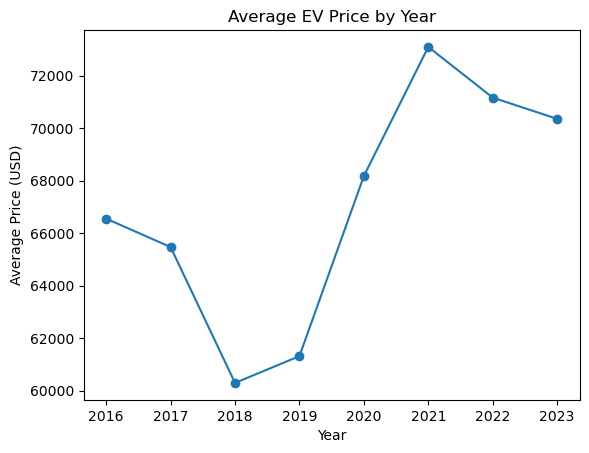

In [4]:
import matplotlib.pyplot as plt

# Load your CSV file
pricing_df = pd.read_csv(csv_file_path)

# Function to handle MSRP ranges and convert to numeric
def clean_msrp(msrp):
    if pd.isna(msrp):
        return None
    msrp = msrp.replace('$', '').replace(',', '').strip()
    if '– ' in msrp:
        low, high = msrp.split('–')
        return (float(low) + float(high)) / 2
    else:
        return float(msrp)

# Apply the function to clean MSRP
pricing_df['MSRP'] = pricing_df['MSRP'].apply(clean_msrp)

# Drop rows where MSRP is NaN
pricing_df = pricing_df.dropna(subset=['MSRP'])

# Calculate the average MSRP by year
avg_prices_per_year = pricing_df.groupby('Year')['MSRP'].mean()

plt.plot(avg_prices_per_year.index, avg_prices_per_year.values, marker='o')
plt.title('Average EV Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Price (USD)')
plt.show()

Year
2016    12333200.0
2017    18855000.0
2018    22904000.0
2019    45448800.0
2020    61134000.0
Name: Electric, dtype: float64


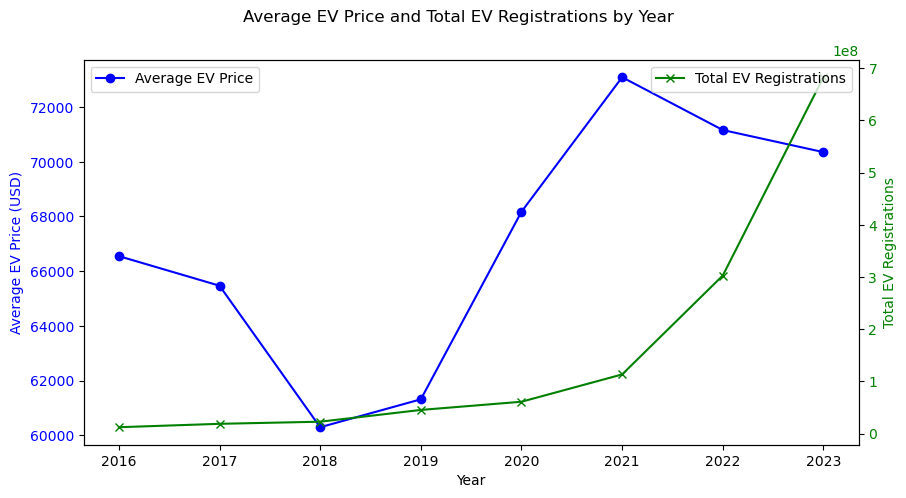

In [5]:
regis_file_path = os.path.join(current_dir, 'csv_data_files', 'ev_registration_data.csv')
registration_df = pd.read_csv(regis_file_path)
# print(type(registration_data))
registration_pricing_df = pd.merge(pricing_df, registration_df, on='Year', how='inner')

def clean_regis(regis):
    if pd.isna(regis):
        return None
    regis = regis.replace(',', '').strip()
    return float(regis)

registration_pricing_df['Electric'] = registration_pricing_df['Electric'].apply(clean_regis)

annual_registrations = registration_pricing_df.groupby('Year')['Electric'].sum()
print(annual_registrations.head())

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the average EV price with ax1
ax1.set_xlabel('Year')
ax1.set_ylabel('Average EV Price (USD)', color='blue')
ax1.plot(avg_prices_per_year.index, avg_prices_per_year.values, label='Average EV Price', color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for total EV registrations
ax2 = ax1.twinx()
ax2.set_ylabel('Total EV Registrations', color='green')
ax2.plot(annual_registrations.index, annual_registrations.values, label='Total EV Registrations', color='green', marker='x')
ax2.tick_params(axis='y', labelcolor='green')

# Add title and legends
fig.suptitle('Average EV Price and Total EV Registrations by Year')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

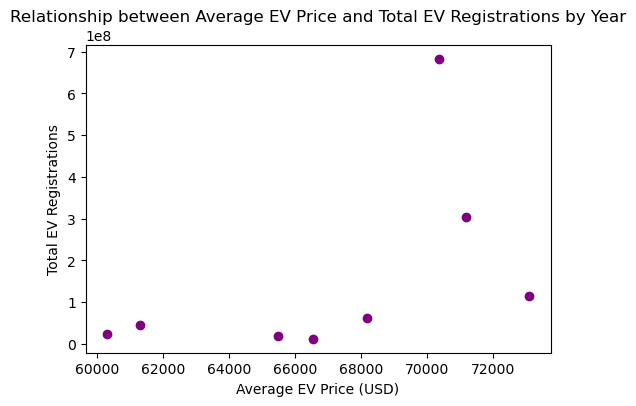

In [6]:
# Group by Year to get the required aggregates
annual_data = registration_pricing_df.groupby('Year').agg({'Electric': 'sum', 'MSRP': 'mean'}).reset_index()

# Plot the relationship using a scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(annual_data['MSRP'], annual_data['Electric'], color='purple', marker='o')

# Add labels and title
plt.xlabel('Average EV Price (USD)')
plt.ylabel('Total EV Registrations')
plt.title('Relationship between Average EV Price and Total EV Registrations by Year')

plt.show()

   Year       State   Electric          MSRP
0  2016     Alabama    11000.0  66551.136364
1  2016      Alaska     4400.0  66551.136364
2  2016     Arizona   103400.0  66551.136364
3  2016    Arkansas     4400.0  66551.136364
4  2016  California  3113000.0  66551.136364


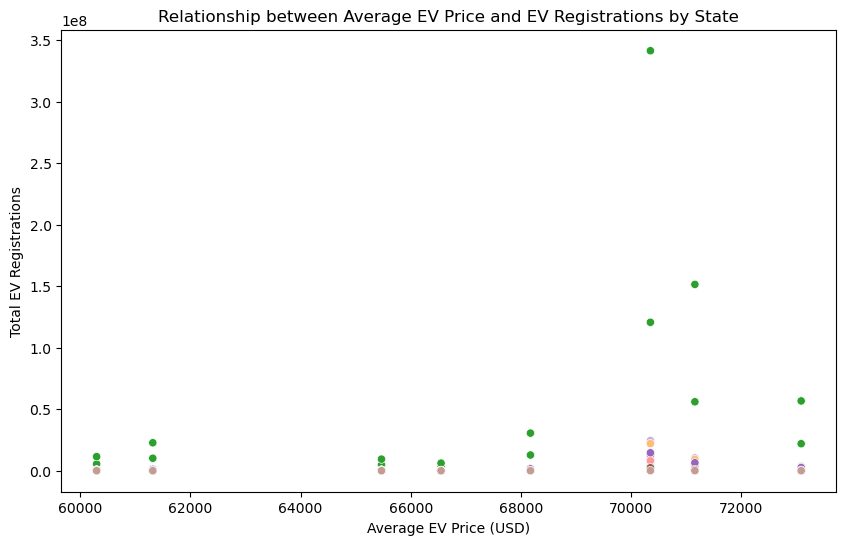

In [7]:
import seaborn as sns

state_annual_data = registration_pricing_df.groupby(['Year', 'State']).agg({'Electric': 'sum', 'MSRP': 'mean'}).reset_index()

print(state_annual_data.head())

plt.figure(figsize=(10, 6))
sns.scatterplot(data=state_annual_data, x='MSRP', y='Electric', hue='State', palette='tab20', legend=False)
plt.title('Relationship between Average EV Price and EV Registrations by State')
plt.xlabel('Average EV Price (USD)')
plt.ylabel('Total EV Registrations')
plt.show()
